In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3


In [ ]:
dataset_path = "/content/drive/MyDrive/RP DATASET/Train"

In [ ]:
dataset_path

'/content/drive/MyDrive/RP DATASET/Train'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1600 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names

class_names

['Apple', 'Banana', 'Grape', 'Mango']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 1 3 2 0 0 0 3 0 0 2 1 3 2 1 3 0 3 3 1 3 2 0 3 3 3 0 3 0 3 1 1]


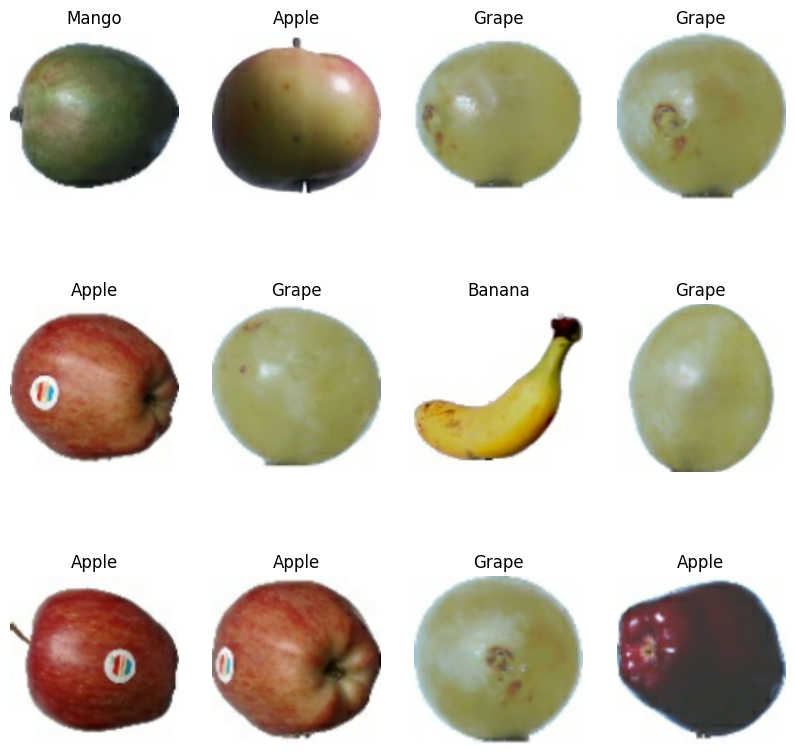

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset

#### Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

50

In [ ]:
train_size = 0.8
len(dataset)*train_size

40.0

In [ ]:
train_ds = dataset.take(40)
len(train_ds)

40

In [ ]:
test_ds = dataset.skip(40)
len(test_ds)

10

In [ ]:
val_size=0.1
len(dataset)*val_size

5.0

In [ ]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [ ]:
test_ds = test_ds.skip(5)
len(test_ds)

5

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
used a CNN coupled with a Softmax activation in the output layer. Also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model

Used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
from re import VERBOSE
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 343s 530ms/step - accuracy: 0.2693 - loss: 1.5106 - val_accuracy: 0.4688 - val_loss: 1.3640
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.4699 - loss: 1.0381 - val_accuracy: 0.5063 - val_loss: 0.9963
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.6245 - loss: 0.6836 - val_accuracy: 0.7812 - val_loss: 0.5200
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.7598 - loss: 0.4950 - val_accuracy: 0.8438 - val_loss: 0.3081
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 0.7195 - loss: 0.8323 - val_accuracy: 0.9125 - val_loss: 0.3689
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.9174 - loss: 0.2515 - val_accuracy: 0.7937 - val_loss: 0.4112
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.9244 - loss: 0.2144 - val_accuracy: 0.7437 - val_loss: 0.6477
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.9471 - loss: 0.1578 - val_acc

In [ ]:
scores = model.evaluate(test_ds)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9261 - loss: 0.2642


[0.26429423689842224, 0.9125000238418579]

## Confusion Matrix / Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
y_true = []
y_pred = []

y_true.clear()
y_pred.clear()

In [ ]:
import numpy as np
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [ ]:
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

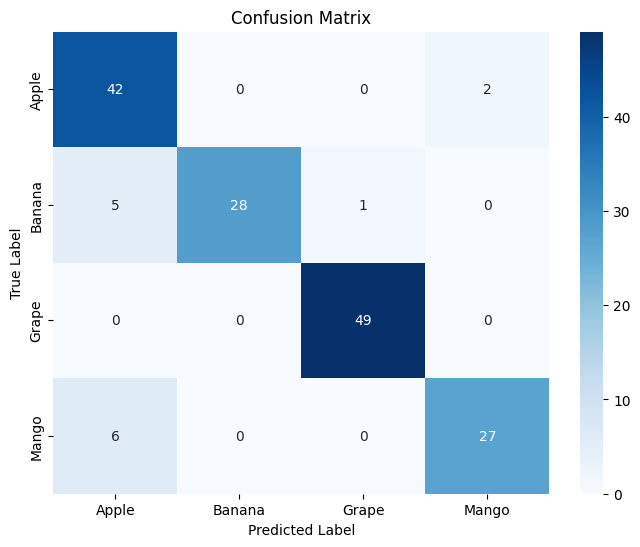

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       Apple       0.79      0.95      0.87        44
      Banana       1.00      0.82      0.90        34
       Grape       0.98      1.00      0.99        49
       Mango       0.93      0.82      0.87        33

    accuracy                           0.91       160
   macro avg       0.93      0.90      0.91       160
weighted avg       0.92      0.91      0.91       160



## Plotting the Accuracy and Loss Curves

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 40}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

13

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.4177823066711426,
 0.9321331977844238,
 0.6015976667404175,
 0.4295196533203125,
 0.6461794376373291]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

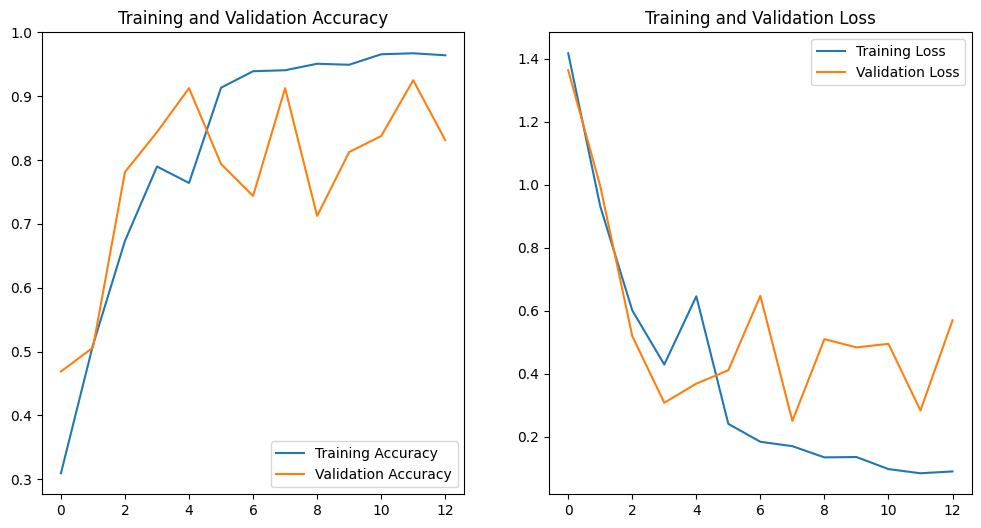

In [ ]:
EPOCHS = 13
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Mango
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
predicted label: Mango


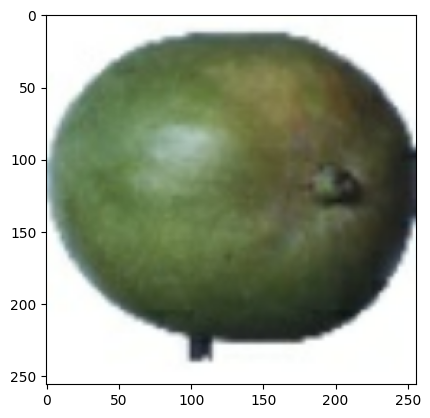

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


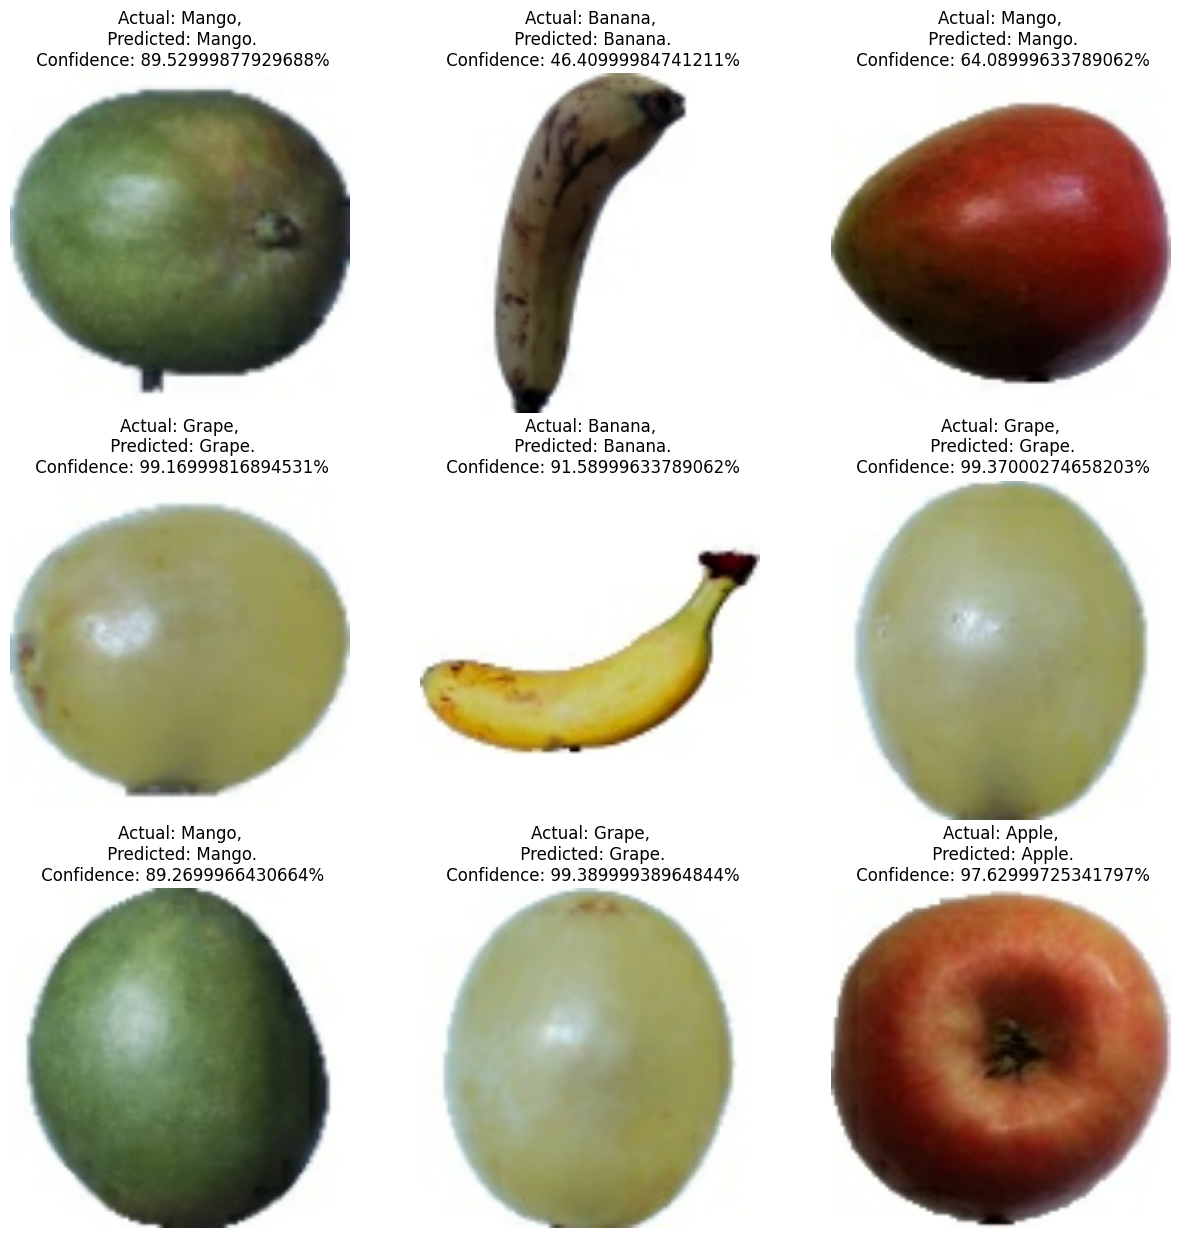

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")